In [81]:
#Load Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_rows', 100)
import warnings
warnings.filterwarnings("ignore")

#Models
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [82]:
#Load Dataset
data=pd.read_csv('./subs.csv')
data.head()

,BAN_hashed,IMSI_hashed,BRAND,DEVICE_MANUFACTURER_TXT,MUNICIPALITY_NM,PROVINCE_STATE_CD,TENURE_DAY_QTY_SCALED,PRICE_PLAN,PROD_TV,PROD_INTERNET,SEGMENT_NM,LOCALITY_NM,LIFESTAGE,THREE_MONTH_AVG_WLN_BILLING_SCALED,THREE_MONTH_AVG_WLS_BILLING_SCALED
0,114717207,906661635071028,T,Apple,SURREY,BC,0.013143,PROMO - Peace of Mind-Unlimited nationwide tal...,1,1,Metro Melting Pot,Midscale Urban Fringe,Middle-Age Families,0.022209,0.052745
1,112418388,906660952816959,K,Samsung,PORT COQUITLAM,BC,0.261786,$45 2GB Unltd min Plan SFD,1,0,Metro Melting Pot,Midscale Urban Fringe,Middle-Age Families,0.029938,0.095285
2,53146188,906660062171958,T,Apple,EDMONTON,AB,0.321214,"Peace of Mind - Unlimited nationwide talk, tex...",1,0,Social Networkers,Young Urban Core,Very Young Singles & Couples,0.021639,0.047167
3,30467094,906660089430135,T,Samsung,CALGARY,AB,0.415714,L&R ULNW 5GB shareable data,1,0,Social Networkers,Young Urban Core,Very Young Singles & Couples,0.017315,0.026276
4,97147194,906661629073089,T,Samsung,VANCOUVER,BC,0.125429,3GB Premium 85 - non-share 500 nationwide minu...,1,0,Social Networkers,Young Urban Core,Very Young Singles & Couples,0.024490,0.051316


## Data Preparation

In [83]:
#Check Datatypes
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   BAN_hashed                          20000 non-null  int64  
 1   IMSI_hashed                         20000 non-null  int64  
 2   BRAND                               20000 non-null  object 
 3   DEVICE_MANUFACTURER_TXT             19983 non-null  object 
 4   MUNICIPALITY_NM                     20000 non-null  object 
 5   PROVINCE_STATE_CD                   19995 non-null  object 
 6   TENURE_DAY_QTY_SCALED               20000 non-null  float64
 7   PRICE_PLAN                          20000 non-null  object 
 8   PROD_TV                             20000 non-null  int64  
 9   PROD_INTERNET                       20000 non-null  int64  
 10  SEGMENT_NM                          20000 non-null  object 
 11  LOCALITY_NM                         20000

In [84]:
data.nunique()

BAN_hashed                            18557
IMSI_hashed                           18814
BRAND                                     2
DEVICE_MANUFACTURER_TXT                  44
MUNICIPALITY_NM                         998
PROVINCE_STATE_CD                        13
TENURE_DAY_QTY_SCALED                  7230
PRICE_PLAN                              729
PROD_TV                                   2
PROD_INTERNET                             2
SEGMENT_NM                               58
LOCALITY_NM                              20
LIFESTAGE                                 9
THREE_MONTH_AVG_WLN_BILLING_SCALED    12664
THREE_MONTH_AVG_WLS_BILLING_SCALED    14149
dtype: int64

In [85]:
data['DEVICE_MANUFACTURER_TXT'] = data['DEVICE_MANUFACTURER_TXT'].str.lower()

In [86]:
data = data.drop_duplicates(subset=['BAN_hashed'], keep='last')

In [87]:
data.replace('na', np.nan, inplace=True)

In [88]:
data['THREE_MONTH_AVG_WLN_BILLING_SCALED'] = data['THREE_MONTH_AVG_WLN_BILLING_SCALED'].replace(np.nan, 0)
data['THREE_MONTH_AVG_WLS_BILLING_SCALED'] = data['THREE_MONTH_AVG_WLS_BILLING_SCALED'].replace(np.nan, 0)

In [89]:
data['DEVICE_MANUFACTURER_TXT'] = data['DEVICE_MANUFACTURER_TXT'].replace(np.nan, "BrandX")
data['PROVINCE_STATE_CD'] = data['PROVINCE_STATE_CD'].replace(np.nan, "NL")

In [90]:
data.isnull().sum()

BAN_hashed                            0
IMSI_hashed                           0
BRAND                                 0
DEVICE_MANUFACTURER_TXT               0
MUNICIPALITY_NM                       0
PROVINCE_STATE_CD                     0
TENURE_DAY_QTY_SCALED                 0
PRICE_PLAN                            0
PROD_TV                               0
PROD_INTERNET                         0
SEGMENT_NM                            0
LOCALITY_NM                           0
LIFESTAGE                             0
THREE_MONTH_AVG_WLN_BILLING_SCALED    0
THREE_MONTH_AVG_WLS_BILLING_SCALED    0
dtype: int64

Class Split
1    11395
0     7162
Name: PROD_INTERNET, dtype: int64


Text(0, 0.5, 'Count')

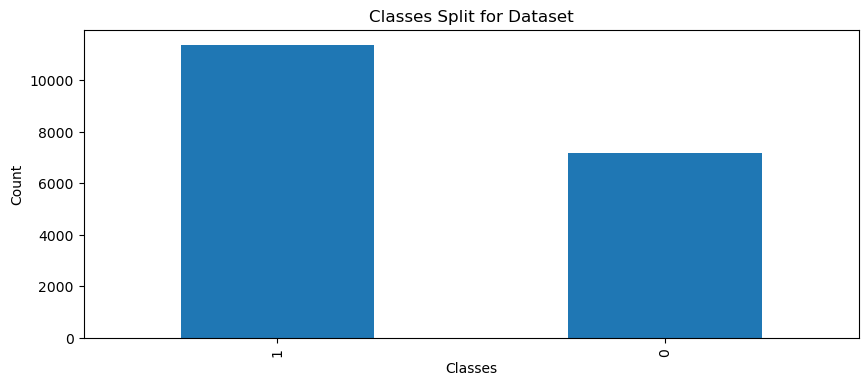

In [91]:
#Class Balance Check
print('Class Split')
print(data['PROD_INTERNET'].value_counts())
data['PROD_INTERNET'].value_counts().plot.bar(figsize=(10,4),title='Classes Split for Dataset')
plt.xlabel('Classes')
plt.ylabel('Count')

In [92]:
#Find Independent Column Correlations
def correlation(dataset,threshold):
    col_corr= [] # List of correlated columns
    corr_matrix=dataset.corr() #finding correlation between columns
    for i in range (len(corr_matrix.columns)): #Number of columns
        for j in range (i):
            if abs(corr_matrix.iloc[i,j])>threshold: #checking correlation between columns
                colName=(corr_matrix.columns[i], corr_matrix.columns[j]) #getting correlated columns
                col_corr.append(colName) #adding correlated column name
    return col_corr #returning set of column names
col=correlation(data,0.8)
print('Correlated columns @ 0.8:', col)

Correlated columns @ 0.8: []


In [93]:
X = data.drop(columns=['PROD_INTERNET','BAN_hashed'],axis=1)
y = data['PROD_INTERNET']

## Data Preprocessing

In [94]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
cat_less_than_60 = [col for col in data.columns if data[col].dtype =='object' and data[col].nunique()  < 60]
cat_more_than_60 = [col for col in data.columns if data[col].dtype =='object' and data[col].nunique()  >= 60]


from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import category_encoders as ce

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder = ce.CountEncoder(normalize=True)

preprocessor = ColumnTransformer(
    [
        ("oh", oh_transformer, cat_less_than_60),
         ("sc", numeric_transformer, num_features),
         ("FreqEn", encoder, cat_more_than_60)    

    ]
)

In [95]:
X_new = preprocessor.fit_transform(X)
X_new.shape

(18557, 147)

In [96]:
preprocessor

ColumnTransformer(transformers=[('oh',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse=False),
                                 ['BRAND', 'DEVICE_MANUFACTURER_TXT',
                                  'PROVINCE_STATE_CD', 'SEGMENT_NM',
                                  'LOCALITY_NM', 'LIFESTAGE']),
                                ('sc', StandardScaler(),
                                 Index(['IMSI_hashed', 'TENURE_DAY_QTY_SCALED', 'PROD_TV',
       'THREE_MONTH_AVG_WLN_BILLING_SCALED',
       'THREE_MONTH_AVG_WLS_BILLING_SCALED'],
      dtype='object')),
                                ('FreqEn',
                                 CountEncoder(combine_min_nan_groups=True,
                                              normalize=True),
                                 ['MUNICIPALITY_NM', 'PRICE_PLAN'])])

In [97]:
X_new_df = pd.DataFrame(X_new, columns=preprocessor.get_feature_names_out()).head()
X_new_df

,oh__BRAND_K,oh__BRAND_T,oh__DEVICE_MANUFACTURER_TXT_BrandX,oh__DEVICE_MANUFACTURER_TXT_alcatel,oh__DEVICE_MANUFACTURER_TXT_alcatel / tcl,oh__DEVICE_MANUFACTURER_TXT_apple,oh__DEVICE_MANUFACTURER_TXT_asus,oh__DEVICE_MANUFACTURER_TXT_blackberry,oh__DEVICE_MANUFACTURER_TXT_blu,oh__DEVICE_MANUFACTURER_TXT_cat,...,oh__LIFESTAGE_Very Young Singles & Couples,oh__LIFESTAGE_Young Families,oh__LIFESTAGE_Younger Singles & Couples,sc__IMSI_hashed,sc__TENURE_DAY_QTY_SCALED,sc__PROD_TV,sc__THREE_MONTH_AVG_WLN_BILLING_SCALED,sc__THREE_MONTH_AVG_WLS_BILLING_SCALED,FreqEn__MUNICIPALITY_NM,FreqEn__PRICE_PLAN
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.706472,-1.161766,0.637803,-0.180496,-0.675933,0.037560,0.082718
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.632581,0.124702,0.637803,0.339827,-0.012108,0.005173,0.013256
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-0.769325,0.432184,0.637803,-0.218896,-0.762969,0.114889,0.177884
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.697031,-0.580804,0.637803,-0.026970,-0.698222,0.042895,0.000216
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,-0.701787,-0.797372,-1.567883,-0.376482,-0.219124,0.042895,0.019561


In [98]:
import pickle
pickle.dump(preprocessor, open('preprocessor.pkl','wb')) #save model object

In [99]:
# separate dataset into train and test
from sklearn.model_selection import train_test_split, GridSearchCV
X_train, X_test, y_train, y_test = train_test_split(X_new,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((14845, 147), (3712, 147))

## Model Competition

In [100]:
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score
def evaluate_model(true, predicted):
    recall = recall_score(true, predicted)
    f1 = f1_score(true, predicted)
    precision = precision_score(true, predicted)
    accuracy = accuracy_score(true, predicted)
    return recall, f1, precision, accuracy

In [101]:
models = {
    'Logistic Regression':LogisticRegression(solver='lbfgs',
                                                   class_weight='balanced',random_state=100),
    'SVM': SVC(random_state=100),
    'Random Forest':RandomForestClassifier(random_state=100),
    'DTC':DecisionTreeClassifier(random_state=100),
    'XGB':XGBClassifier(random_state=100)
}
model_list = []
recall =[]
f1 =[]
precision =[]
accuracy =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_recall , model_train_f1, model_train_precision, model_train_accuracy = evaluate_model(y_train, y_train_pred)
    model_test_recall , model_test_f1, model_test_precision, model_test_accuracy = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print('Model performance for Training set')
    print("- recall: {:.4f}".format(model_train_recall))
    print("- f1: {:.4f}".format(model_train_f1))
    print("- precision: {:.4f}".format(model_train_precision))
    print("- accuracy: {:.4f}".format(model_train_accuracy))

    print('----------------------------------')
    
    print('Model performance for Training set')
    print("- recall: {:.4f}".format(model_test_recall))
    print("- f1: {:.4f}".format(model_test_f1))
    print("- precision: {:.4f}".format(model_test_precision))
    print("- accuracy: {:.4f}".format(model_test_accuracy))
    recall.append(model_test_recall)
    f1.append(model_test_f1)
    precision.append(model_test_precision)
    accuracy.append(model_test_accuracy)

    print('='*35)
    print('\n')

Logistic Regression
Model performance for Training set
- recall: 0.6076
- f1: 0.7301
- precision: 0.9146
- accuracy: 0.7248
----------------------------------
Model performance for Training set
- recall: 0.6223
- f1: 0.7377
- precision: 0.9056
- accuracy: 0.7260


SVM
Model performance for Training set
- recall: 0.7584
- f1: 0.8024
- precision: 0.8518
- accuracy: 0.7711
----------------------------------
Model performance for Training set
- recall: 0.7415
- f1: 0.7869
- precision: 0.8382
- accuracy: 0.7513


Random Forest
Model performance for Training set
- recall: 1.0000
- f1: 1.0000
- precision: 1.0000
- accuracy: 1.0000
----------------------------------
Model performance for Training set
- recall: 0.7694
- f1: 0.7797
- precision: 0.7903
- accuracy: 0.7309


DTC
Model performance for Training set
- recall: 1.0000
- f1: 1.0000
- precision: 1.0000
- accuracy: 1.0000
----------------------------------
Model performance for Training set
- recall: 0.7707
- f1: 0.7546
- precision: 0.7391

## Final Model Selection

In [102]:
pd.DataFrame(list(zip(model_list, recall, f1, precision, accuracy)), columns=['Model Name', 'recall', 'f1', 'precision', 'accuracy']).sort_values(by=["f1"],ascending=False)

,Model Name,recall,f1,precision,accuracy
1,SVM,0.741514,0.786885,0.838170,0.751347
4,XGB,0.761532,0.782123,0.803859,0.737338
2,Random Forest,0.769365,0.779713,0.790344,0.730873
3,DTC,0.770670,0.754580,0.739149,0.689655
0,Logistic Regression,0.622280,0.737684,0.905636,0.726024


## Model Tuning

In [103]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with StandardScaler and SVM
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Standardize features
    ('svm', SVC(kernel='rbf', probability=True))  # SVM classifier with RBF kernel
])

# Define hyperparameter grid for GridSearch
param_grid = {
    'svm__C': [0.1, 1],       # SVM regularization parameter
    'svm__gamma': [0.01, 0.1]  # Kernel coefficient
}

# Perform GridSearch with Cross-Validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the Best Parameters and Best Estimator
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the Model on the Test Set
accuracy = best_model.score(X_test, y_test)
print(f'Best Parameters: {best_params}')
print(f'Accuracy on the test set: {accuracy}')


Best Parameters: {'svm__C': 1, 'svm__gamma': 0.01}
Accuracy on the test set: 0.7491918103448276


In [104]:
# Pickle the best model to a file
with open('best_svc_model.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

In [105]:
svc_pred = best_model.predict(X_test)

import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix  
# Evaluate the Model on the Test Set
print('Support Vector Machine: Final Classification Performance test :')
print('-------------------------------------------------------')
print('Accuracy        : ', metrics.accuracy_score(y_test, svc_pred))
print('F1 Score        : ', metrics.f1_score(y_test, svc_pred))
print('Precision       : ', metrics.precision_score(y_test, svc_pred))
print('Recall          : ', metrics.recall_score(y_test, svc_pred))
print('Confusion Matrix:\n ', confusion_matrix(y_test, svc_pred))
print(classification_report(y_test, svc_pred, target_names=['PROD_INTERNET=0', 'PROD_INTERNET=1']))

Support Vector Machine: Final Classification Performance test :
-------------------------------------------------------
Accuracy        :  0.7491918103448276
F1 Score        :  0.782425800420659
Precision       :  0.8450277637556789
Recall          :  0.7284595300261096
Confusion Matrix:
  [[1107  307]
 [ 624 1674]]
                 precision    recall  f1-score   support

PROD_INTERNET=0       0.64      0.78      0.70      1414
PROD_INTERNET=1       0.85      0.73      0.78      2298

       accuracy                           0.75      3712
      macro avg       0.74      0.76      0.74      3712
   weighted avg       0.77      0.75      0.75      3712



In [106]:
best_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('oh',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['BRAND',
                                                   'DEVICE_MANUFACTURER_TXT',
                                                   'PROVINCE_STATE_CD',
                                                   'SEGMENT_NM', 'LOCALITY_NM',
                                                   'LIFESTAGE']),
                                                 ('sc', StandardScaler(),
                                                  Index(['IMSI_hashed', 'TENURE_DAY_QTY_SCALED', 'PROD_TV',
       'THREE_MONTH_AVG_WLN_BILLING_SCALED',
       'THREE_MONTH_AVG_WLS_BILLING_SCALED'],
      dtype='object')),
                                                 ('FreqEn',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               normalize=True),
                                                  ['MUNICIPALITY_NM',
                                                   'PRICE_PLAN'])])),
                ('svm', SVC(C=1, gamma=0.01, probability=True))])

In [107]:
pickled_model=pickle.load(open('best_svc_model.pkl','rb'))

#### Prediction Check

In [108]:
test = data.drop(columns=['PROD_INTERNET','BAN_hashed'],axis=1).iloc[[3000]]
test

,IMSI_hashed,BRAND,DEVICE_MANUFACTURER_TXT,MUNICIPALITY_NM,PROVINCE_STATE_CD,TENURE_DAY_QTY_SCALED,PRICE_PLAN,PROD_TV,SEGMENT_NM,LOCALITY_NM,LIFESTAGE,THREE_MONTH_AVG_WLN_BILLING_SCALED,THREE_MONTH_AVG_WLS_BILLING_SCALED
3259,906660106760157,T,zte,COUNTY OF GP NO.1,AB,0.053714,Wireless Internet 500 - GF,0,Turbo Burbs,Suburban Elite,Middle-Age Families,0.019,0.091328


In [109]:
pickled_model.predict(test)

array([1], dtype=int64)

## Feature Importance Extraction

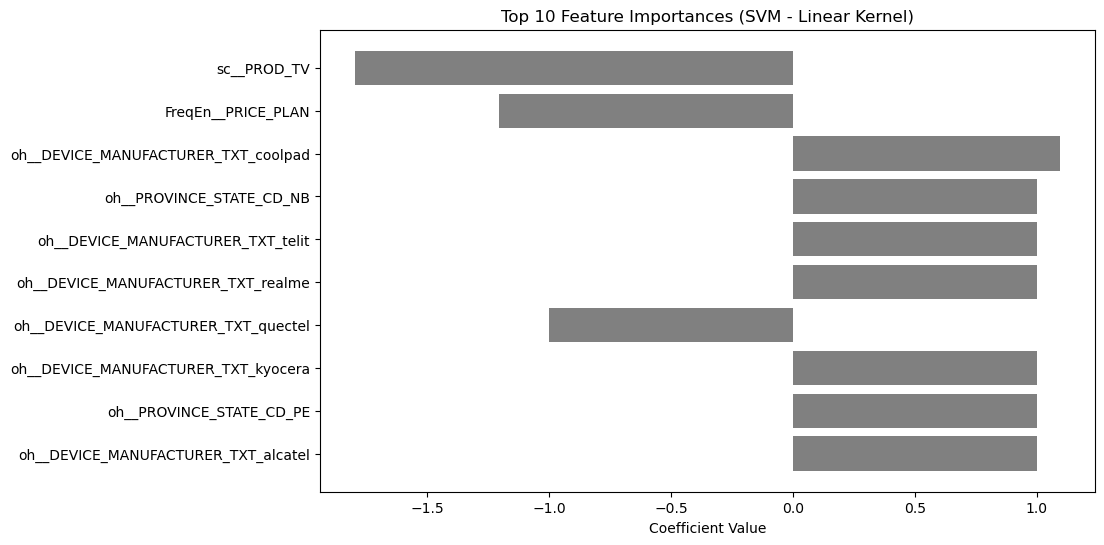

In [110]:
# Create and fit an SVM classifier with a linear kernel
clf = SVC(kernel='linear')
clf.fit(X_new, y)

# Get the coefficients (weights) of the SVM model
coefficients = clf.coef_[0]

# Get the indices of the top 10 features with the highest absolute coefficients
top_feature_indices = np.argsort(np.abs(coefficients))[-10:]

# Get the corresponding feature names
feature_names = X_new_df.columns

# Get the top 10 feature coefficients and names
top_coefficients = coefficients[top_feature_indices]
top_feature_names = [feature_names[i] for i in top_feature_indices]

# Create a bar plot to visualize the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(range(len(top_coefficients)), top_coefficients, align='center',color='grey')
plt.yticks(range(len(top_coefficients)), top_feature_names)
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Importances (SVM - Linear Kernel)')
plt.show()

Text(0.5, 0, 'Absolute Coefficient Value')

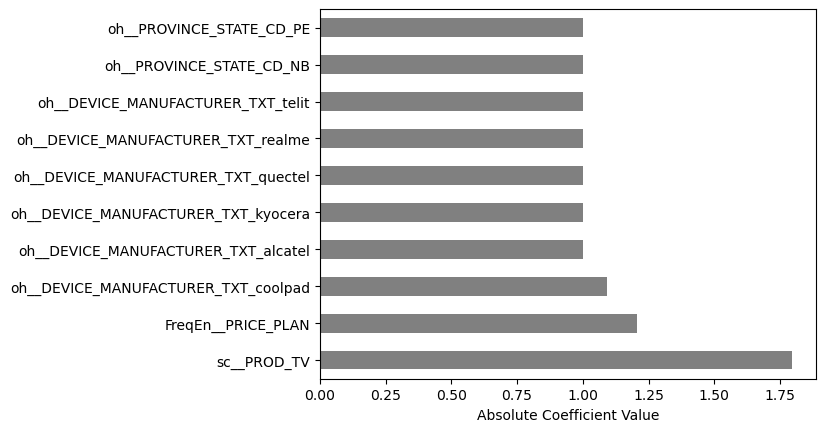

In [111]:
pd.Series(abs(clf.coef_[0]), index=feature_names).nlargest(10).plot(kind='barh',color='grey')
plt.xlabel('Absolute Coefficient Value')

In [112]:
score = best_model.predict_proba(X_test)

In [113]:
X_new_df1 = pd.DataFrame(X_test, columns=X.columns)
eval_df = pd.merge(X_new_df1, data['BAN_hashed'], left_index = True, right_index = True)
eval_df = pd.merge(eval_df, y_test, left_index = True, right_index = True)
eval_df['Score'] = score[:,1]
eval_df.head()


,IMSI_hashed,BRAND,DEVICE_MANUFACTURER_TXT,MUNICIPALITY_NM,PROVINCE_STATE_CD,TENURE_DAY_QTY_SCALED,PRICE_PLAN,PROD_TV,SEGMENT_NM,LOCALITY_NM,LIFESTAGE,THREE_MONTH_AVG_WLN_BILLING_SCALED,THREE_MONTH_AVG_WLS_BILLING_SCALED,BAN_hashed,PROD_INTERNET,Score
4024,906660042404286,T,apple,VANCOUVER,BC,0.361143,L&R ULNW 6GB shareable data,1,Unclassified,Unassigned,Unassigned,0.036612,0.064822,69593775,1,0.667636
5165,906661637105175,T,samsung,PEACHLAND,BC,0.520429,L&R ULNW 6GB shareable data,1,Down to Earth,Lower-Middle Rural,Older Families & Empty Nests,0.028046,0.035066,3920613,1,0.713431
5437,906660105115566,T,apple,EDMONTON,AB,0.230857,YourChoice L&R Premium 70 - Unlimited nationwi...,1,Juggling Acts,Younger Urban Mix,Younger Singles & Couples,0.036271,0.151685,40594509,0,0.376904
7470,906660125028681,T,apple,PRINCE GEORGE,BC,0.001714,"Unlimited 30 - Unlimited nationwide talk, text...",1,Just Getting By,Younger Urban Mix,Younger Singles & Couples,0.023693,0.158718,116353437,1,0.197703
5174,906660950867097,K,apple,VIKING,AB,0.056286,$50 12GB UL min Plan SFD,0,Down to Earth,Lower-Middle Rural,Older Families & Empty Nests,0.018258,0.033996,108765771,1,0.954711


In [114]:
eval_df.to_csv('./eval_df.csv')

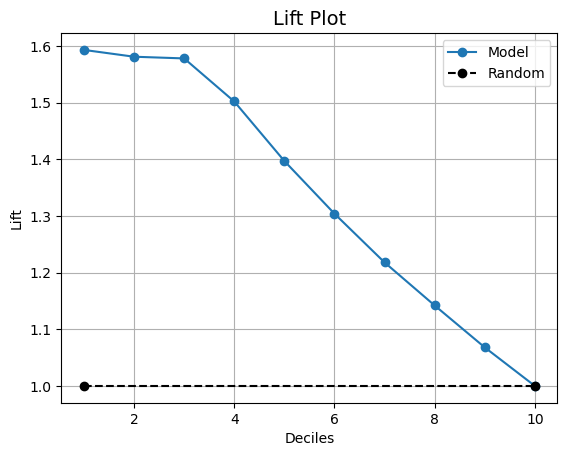

In [115]:
import kds
# CUMMULATIVE LIFT PLOT
kds.metrics.plot_lift(y_test, score[:,1])